Machine Learning Final Project

-- Pre Processing Data

In [2]:
!pip install pandas scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor for regression
from sklearn.metrics import accuracy_score  # or mean_squared_error for regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
df = pd.read_csv('/Users/arianaelahi/Desktop/ML FINAL PROJECT DATA/student/student-mat.csv', sep=';')
print(df.head())
# had to seperate by ; instead of the default , bc that is standard practice is european countries

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


In [4]:
# Data Cleaning and preprocessing

# Drop G1 and G2 to avoid data leakage
df = df.drop(columns=['G1', 'G2'])

# Binary Encoding for yes/no and binary features
binary_columns = ['sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup',
                  'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0, 'F': 0, 'M': 1, 'U': 1, 'R': 0, 'LE3': 0, 'GT3': 1, 'T': 1, 'A': 0})

# One-Hot Encoding for nominal categorical variables
df = pd.get_dummies(df, columns=['school', 'Mjob', 'Fjob', 'reason', 'guardian'], drop_first=True)

print(df.head())



   sex  age  address  famsize  Pstatus  Medu  Fedu  traveltime  studytime  \
0    0   18        1        1        0     4     4           2          2   
1    0   17        1        1        1     1     1           1          2   
2    0   15        1        0        1     1     1           1          2   
3    0   15        1        1        1     4     2           1          3   
4    0   16        1        1        1     3     3           1          2   

   failures  ...  Mjob_teacher  Fjob_health  Fjob_other  Fjob_services  \
0         0  ...         False        False       False          False   
1         0  ...         False        False        True          False   
2         3  ...         False        False        True          False   
3         0  ...         False        False       False           True   
4         0  ...         False        False        True          False   

   Fjob_teacher  reason_home  reason_other  reason_reputation  \
0          True        Fals

In [5]:
# standardization for Z-score

# Define X and y
X = df.drop(columns=['G3'])  # Features
y = df['G3']                 # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


RANDOM FOREST- VANILLA

Classification Report:
              precision    recall  f1-score   support

        Fail       0.57      0.15      0.24        27
        Pass       0.68      0.94      0.79        52

    accuracy                           0.67        79
   macro avg       0.63      0.55      0.51        79
weighted avg       0.64      0.67      0.60        79


Top 10 Important Features:
absences: 0.0923
failures: 0.0683
goout: 0.0586
age: 0.0562
freetime: 0.0472
Fedu: 0.0415
health: 0.0413
Medu: 0.0404
famrel: 0.0374
Walc: 0.0346


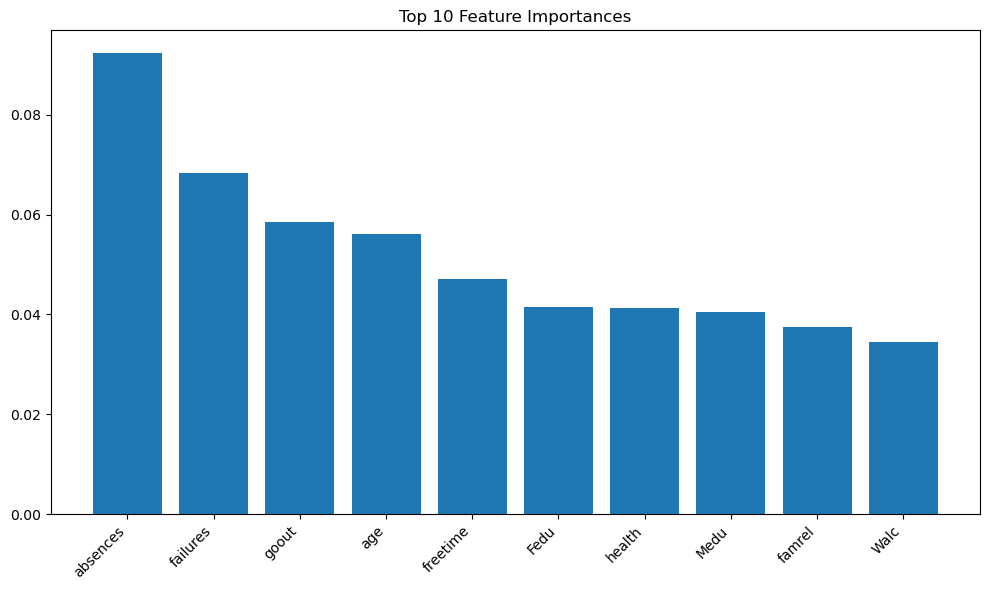

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Convert y to binary (Pass/Fail)
y_binary = y.apply(lambda grade: 1 if grade >= 10 else 0)  # 1 = Pass, 0 = Fail

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_binary[y_train.index])

# Predict on test set
y_pred = rf.predict(X_test_scaled)

# Classification report
print("Classification Report:")
print(classification_report(y_binary[y_test.index], y_pred, target_names=["Fail", "Pass"]))

# Feature Importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top10_indices = indices[:10]

print("\nTop 10 Important Features:")
for i in top10_indices:
    print(f"{X.columns[i]}: {importances[i]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[top10_indices])
plt.xticks(range(10), [X.columns[i] for i in top10_indices], rotation=45, ha="right")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


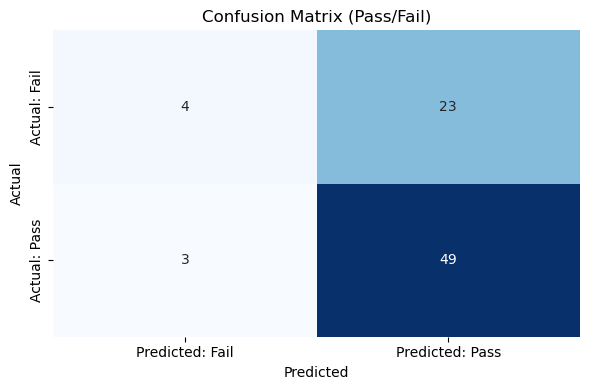

In [ ]:
# Heat Map - Vanilla

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted: Fail", "Predicted: Pass"],
            yticklabels=["Actual: Fail", "Actual: Pass"])
plt.title("Confusion Matrix (Pass/Fail)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


RANDOM FOREST - Tuned

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv('/Users/arianaelahi/Desktop/ML FINAL PROJECT DATA/student/student-mat.csv', sep=';')
df = df.drop(columns=['G1', 'G2'])

# Binary encoding
binary_columns = ['sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup',
                  'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0, 'F': 0, 'M': 1, 'U': 1, 'R': 0, 'LE3': 0, 'GT3': 1, 'T': 1, 'A': 0})

# One-hot encoding
df = pd.get_dummies(df, columns=['school', 'Mjob', 'Fjob', 'reason', 'guardian'], drop_first=True)

# Features and target
X = df.drop(columns=['G3'])
y = (df['G3'] >= 10).astype(int)  # 1 = Pass, 0 = Fail

# Split BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE ONLY to training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# GridSearch for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='f1',
                           verbose=1)

# Train on balanced training set
grid_search.fit(X_train_bal, y_train_bal)

# Best model
best_rf = grid_search.best_estimator_

# Predict on untouched test set
y_pred = best_rf.predict(X_test_scaled)

# Report
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report (Pass First):")
report = classification_report(y_test, y_pred, target_names=["Fail", "Pass"])
print(report)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Classification Report (Pass First):
              precision    recall  f1-score   support

        Fail       0.58      0.26      0.36        27
        Pass       0.70      0.90      0.79        52

    accuracy                           0.68        79
   macro avg       0.64      0.58      0.57        79
weighted avg       0.66      0.68      0.64        79



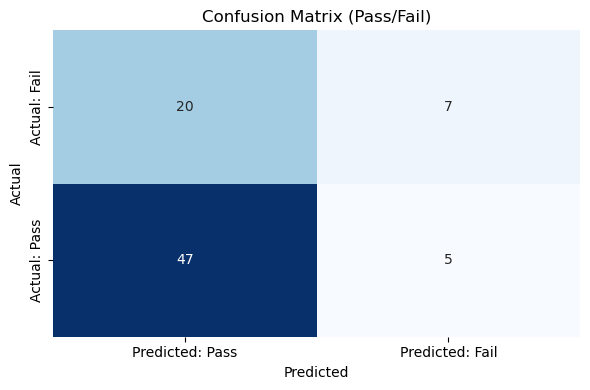


Top 10 Important Features:
failures: 0.0806
absences: 0.0772
age: 0.0583
goout: 0.0535
health: 0.0493
freetime: 0.0491
Fedu: 0.0412
famrel: 0.0386
Medu: 0.0379
studytime: 0.0368


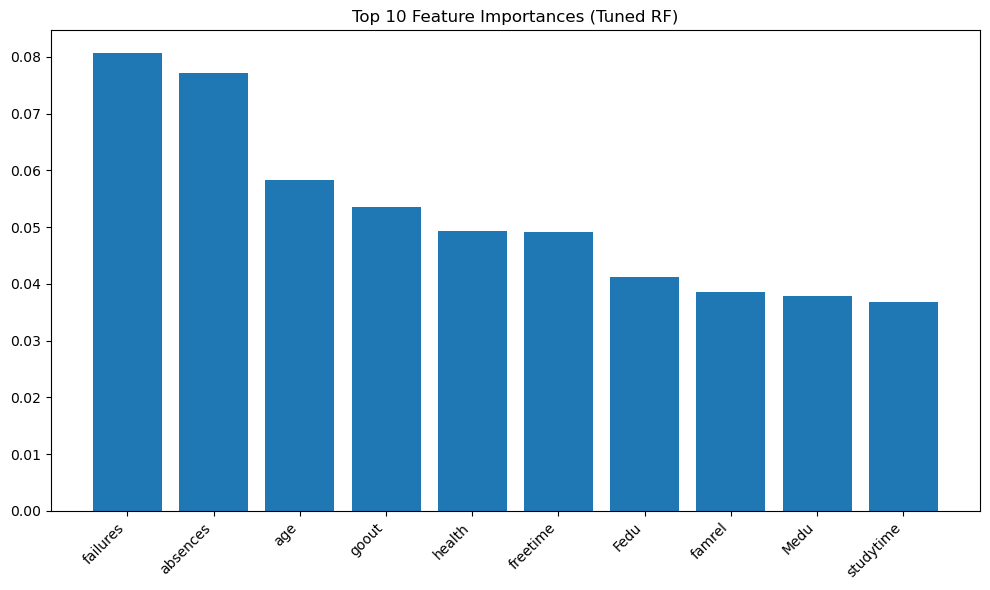

In [27]:
# Confusion matrix with flipped X-axis
cm = confusion_matrix(y_test, y_pred)
cm_flipped = cm[:, [1, 0]]  # Flip columns only
plt.figure(figsize=(6, 4))
sns.heatmap(cm_flipped, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted: Pass", "Predicted: Fail"],
            yticklabels=["Actual: Fail", "Actual: Pass"])
plt.title("Confusion Matrix (Pass/Fail)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Top 10 features
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]

print("\nTop 10 Important Features:")
for i in indices:
    print(f"{X.columns[i]}: {importances[i]:.4f}")

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices])
plt.xticks(range(10), [X.columns[i] for i in indices], rotation=45, ha='right')
plt.title("Top 10 Feature Importances (Tuned RF)")
plt.tight_layout()
plt.show()